In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
import scipy.misc
from PIL import Image
import scipy.io
import os
import cv2
import math
import scipy
import scipy.ndimage.interpolation as sni
import skimage.color as color

# Make sure that caffe is on the python path:
caffe_root = '/home/xu/myWorkspace/LSTM/'  
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
caffe.set_mode_cpu()
#caffe.set_device(0)

In [2]:
# load pretrain caffe model for inference
net = caffe.Net( '../SUNRGBD/deploy.prototxt', '../SUNRGBD/SUNRGBD_final.caffemodel', caffe.TEST)

In [3]:
# crop image to 426*426*3 using central crop
def img_middle_crop(image):
    start_h = np.uint8((image.shape[0] - 426) / 2)
    start_w = np.uint8((image.shape[1] - 426) / 2)
    end_h = start_h + 426
    end_w = start_w + 426
    croped_img = image[start_h:end_h, start_w:end_w, :]
    return croped_img

In [4]:
def prepare_blob(image_name, hha_name):
    # read image and hha data
    image_blob = caffe.io.load_image(image_name)*255.
    hha_blob = caffe.io.load_image(hha_name)*255.
    
    # crop image
    image_blob = img_middle_crop(image_blob)
    hha_blob = img_middle_crop(hha_blob)
    
    image_blob = image_blob[:,:,::-1]                 # convert from RGB to BGR
    
    # subtract the mean of BGR
    image_blob -= np.array((110.324,116.435,125.793))
    image_blob = np.transpose(image_blob, [2, 0, 1])     # permute width and height
    
    hha_blob = hha_blob[:, :, ::-1]                  # convert from HHA to AHH
    # subtract the mean of AHH
    hha_blob -= np.array((115.042,231.247,20.523))
    hha_blob = np.transpose(hha_blob, [2, 0, 1])         # permute width and height
    
    return image_blob, hha_blob

In [5]:
# Make sure gt, output using the same colormap
def myimagesc(image, mapping):
    new_image = np.zeros((image.shape[0], image.shape[1], 3), dtype="float32")
    for i in xrange(image.shape[0]):
        for j in xrange(image.shape[1]):
            index = image[i,j]
            new_image[i,j,:] = mapping[index]*256

    new_image = new_image*1.0
    return new_image

In [6]:
# Run one example for demo
image_name = 'images/bedroom.jpg'
gt_name = 'gt/bedroom.jpg'
hha_name = 'hha/bedroom.jpg'
mapping = np.loadtxt("./mapping.txt", dtype="float16")

image_blob, hha_blob = prepare_blob(image_name, hha_name)

# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *image_blob.shape)
net.blobs['data'].data[...] = image_blob

net.blobs['HHAData'].reshape(1, *hha_blob.shape)
net.blobs['HHAData'].data[...] = hha_blob

In [7]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import matplotlib.cm as cm
import matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0)

# obtain the output from the last fcn layer
out = net.forward()
output = out['local_global_conv']
output = np.transpose(output, [2,3,1,0])
output = output.squeeze()
output = np.argmax(output, axis=2)

# Resize the output to the same resolution of image using simpel bilinear interpolation
output = scipy.misc.imresize(output, (426,426), interp='bilinear',mode='F')
#output = scipy.misc.resize(output, (426,426), interp='bilinear',mode='F')
output = output.astype("int8")

output_before = myimagesc(output, mapping)

/home/xu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


0
104


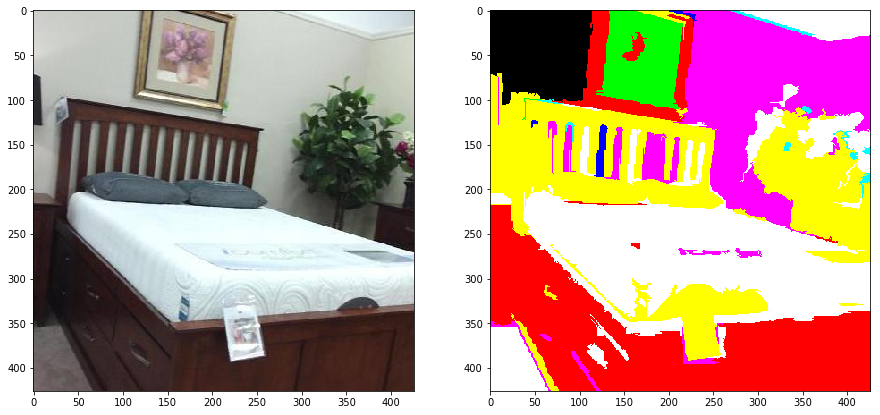

In [8]:
# For visulization purpose, here we use superpixel to smooth our predicted results from our pipeline
from skimage.segmentation import felzenszwalb
original_image = caffe.io.load_image(image_name)
original_gt = caffe.io.load_image(gt_name)

img = img_middle_crop(original_image)
# here we use the default k=500, sigma=0.5, min=50, you can choose different hyperparameters for visulization
segments = felzenszwalb(img, scale=500, sigma=0.5, min_size=50)
print np.min(segments)
print np.max(segments)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
segments1 = myimagesc(segments, mapping)
plt.imshow(segments1)

In [9]:
min_label = np.min(segments)
max_label = np.max(segments)
segments_reshape = np.reshape(segments, (segments.shape[0]*segments.shape[1]))
output_reshape = np.reshape(output, (output.shape[0]*output.shape[1]))

for i in xrange(min_label, max_label):
    inds = np.where(segments_reshape==i)[0]
    if inds.shape[0] != 0:
        select_label = output_reshape[inds]
        tmp_label = np.argmax(np.bincount(select_label))
        segments_reshape[inds] = tmp_label
output_2 = np.reshape(segments_reshape,(segments.shape[0], segments.shape[1]))
output_after = myimagesc(output_2, mapping)

Text(0.5,1,u'Scene labeling after smooth')

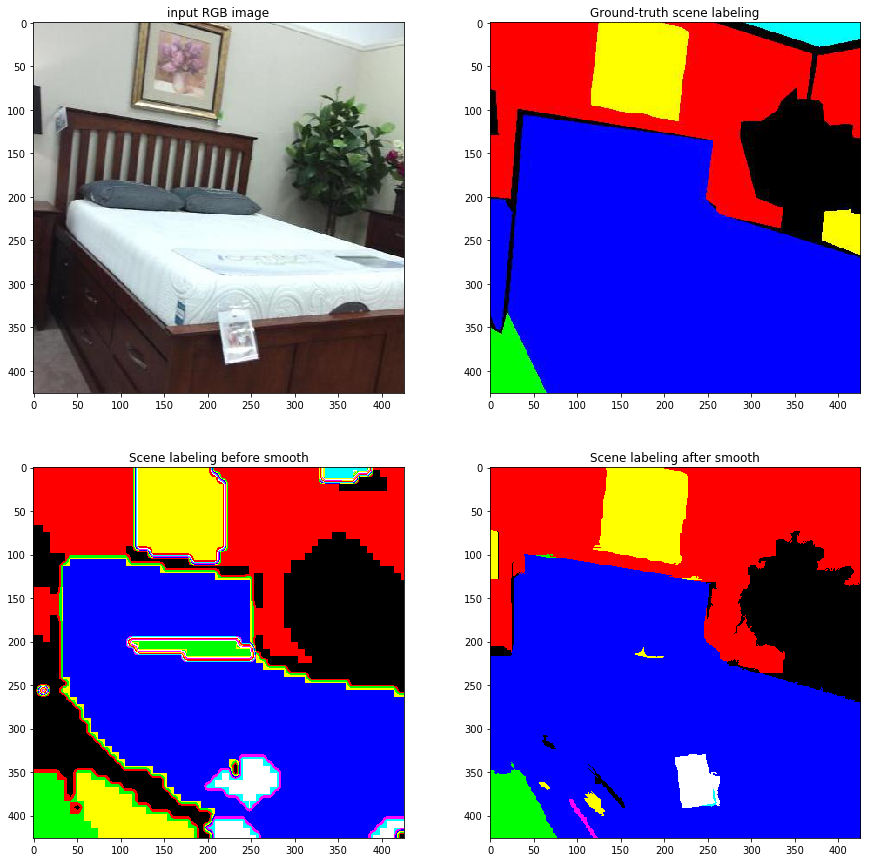

In [10]:
plt.subplot(2,2,1)
plt.imshow(img_middle_crop(original_image))
plt.title("input RGB image")

plt.subplot(2,2,2)
plt.imshow(original_gt)
plt.title("Ground-truth scene labeling")

plt.subplot(2,2,3)
plt.imshow(output_before, vmin=0, vmax=255)
plt.title("Scene labeling before smooth")

plt.subplot(2,2,4)
plt.imshow(output_after, vmin=0, vmax=255)
plt.title("Scene labeling after smooth")